Read model

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Get test data

In [ ]:
!wget "https://putpoznanpl-my.sharepoint.com/:u:/g/personal/dominik_pieczynski_put_poznan_pl/EWIZ_xm8wXpMjQDgF2VQ1csB4QuHPKoj5vDpj6CQi9p-AA?e=yQr6fn&download=1" -O public.zip
!unzip -q public.zip
!rm public.zip

Load model

In [ ]:
!pip install segmentation_models

In [4]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models
# import segmentation_models.metrics
from segmentation_models.losses import dice_loss

# model = create_model()

model_path = '/content/drive/MyDrive/ZPO_projekt/models/model_19'


dice_score = segmentation_models.metrics.FScore(threshold=0.5)

model = keras.models.load_model(model_path, custom_objects={"f1-score": dice_score, "dice_loss": dice_loss})

In [21]:
model.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     6         
_________________________________________________________________
model (Functional)           (None, None, None, 1)     12641169  
Total params: 12,641,175
Trainable params: 12,577,143
Non-trainable params: 64,032
_________________________________________________________________


In [12]:
!mkdir /content/predictions

In [13]:
!mkdir /content/predictions/first
!mkdir /content/predictions/second

In [ ]:
!pip install --upgrade nibabel

In [19]:
import numpy as np
import nibabel as nib

from typing import Tuple, List
from pathlib import Path


def load_raw_volume(path: Path) -> Tuple[np.ndarray, np.ndarray]:
  data: nib.Nifti1Image = nib.load(str(path))
  data = nib.as_closest_canonical(data)
  raw_data = data.get_fdata(caching='unchanged', dtype=np.float32)
  return raw_data, data.affine


def load_labels_volume(path: Path) -> np.ndarray:
  return load_raw_volume(path)[0].astype(np.uint8)


def save_labels(data: np.ndarray, affine: np.ndarray, path: Path):
  nib.save(nib.Nifti1Image(data, affine), str(path))


def show_slices(slices: List[np.ndarray]):
   fig, axes = plt.subplots(1, len(slices))
   for i, data_slice in enumerate(slices):
       axes[i].imshow(data_slice.T, cmap="gray", origin="lower")

In [ ]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt


first_dataset_path = Path('/content/FirstDataset/test')
second_dataset_path = Path('/content/SecondDataset/test')
predictions_base_path = Path('/content/predictions')
first_dataset_predictions_path = predictions_base_path / 'first'
second_dataset_predictions_path = predictions_base_path / 'second'

counter = 1
for scan_path in first_dataset_path.iterdir():
  print(counter)
  counter += 1

  data, affine = load_raw_volume(scan_path)
  labels = np.zeros(data.shape, dtype=np.uint8)

  data_max=np.amax(data)
  data_min=np.amin(data)

  x_size, y_size, z_size = data.shape
  for x_index in range(x_size):
    data_slice = data[x_index]

    data_slice = (data_slice - data_min)/(data_max - data_min)

    data_slice = cv2.resize(data_slice, (128, 128))
    data_slice = data_slice[...,np.newaxis]
    data_slice = data_slice[np.newaxis,...]

    prediction = model.predict(data_slice)
    prediction = prediction.squeeze()

    prediction[prediction<0.05]=0
    prediction[prediction>=0.05]=1

    # plt.imshow(prediction)
    # plt.show()
    
    prediction = cv2.resize(prediction,(z_size,y_size))

    labels[x_index] = prediction

  save_labels(labels, affine, first_dataset_predictions_path / scan_path.name)

# ----------------------------------------------
counter = 1 
for scan_path in second_dataset_path.iterdir():
  print(counter)
  counter += 1

  data, affine = load_raw_volume(scan_path / 'T1w.nii.gz')
  labels = np.zeros(data.shape, dtype=np.uint8)
  
  data_max=np.amax(data)
  data_min=np.amin(data)

  x_size, y_size, z_size = data.shape
  for x_index in range(x_size):
    data_slice = data[x_index]

    data_slice = (data_slice - data_min)/(data_max - data_min)

    data_slice = cv2.resize(data_slice, (128, 128))
    data_slice = data_slice[...,np.newaxis]
    data_slice = data_slice[np.newaxis,...]
    prediction = model.predict(data_slice)
    prediction = prediction.squeeze()

    prediction[prediction<0.05]=0
    prediction[prediction>=0.05]=1

    # plt.imshow(prediction)
    # plt.show()

    prediction = cv2.resize(prediction,(z_size,y_size))

    labels[x_index] = prediction
  
  save_labels(labels, affine, second_dataset_predictions_path / f'{scan_path.name}.nii.gz')


Save predictions

In [ ]:
!zip -r predictions.zip /content/predictions

In [ ]:
!cp /content/predictions.zip -r /content/drive/MyDrive/ZPO_projekt

Show predictions of known data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


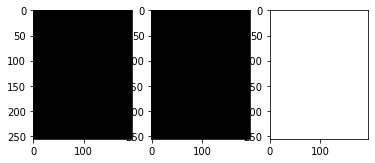

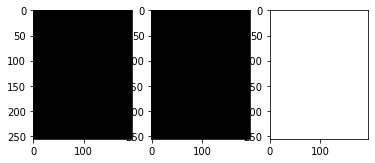

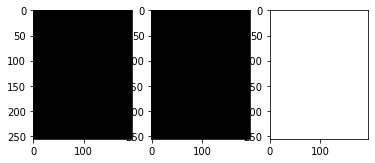

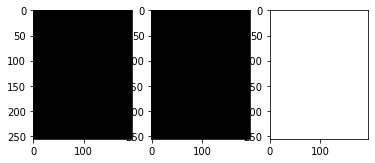

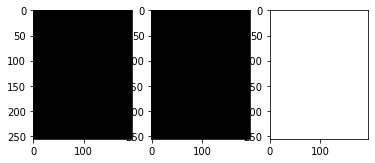

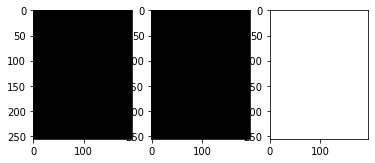

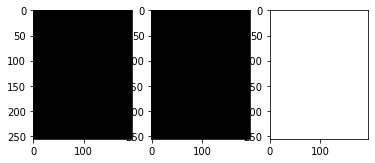

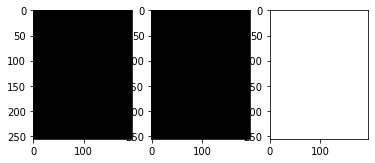

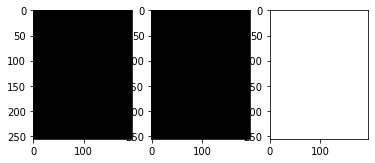

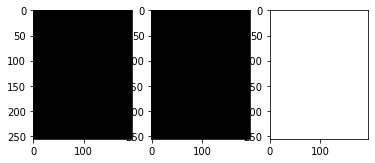

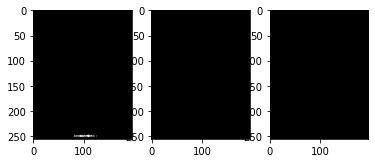

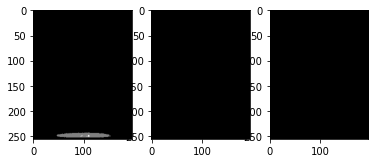

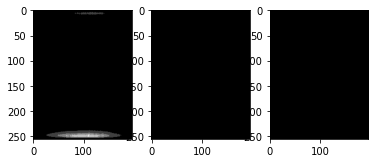

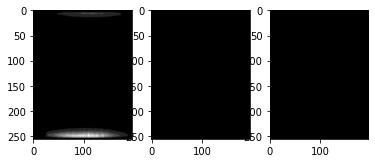

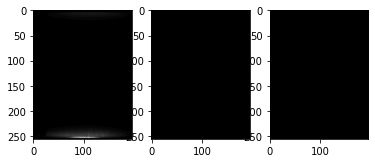

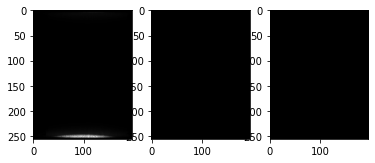

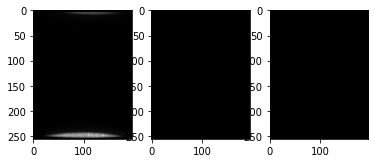

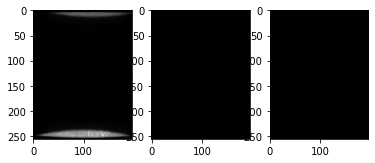

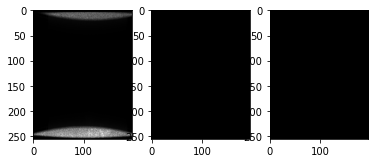

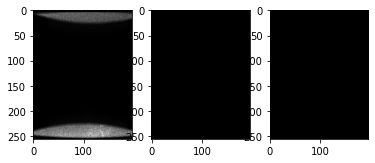

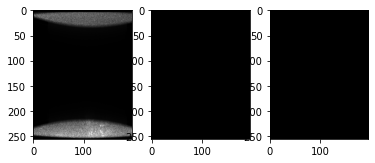

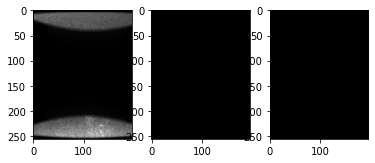

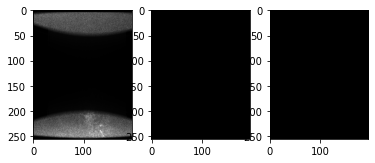

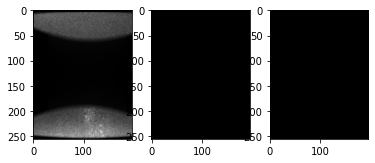

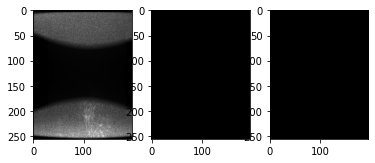

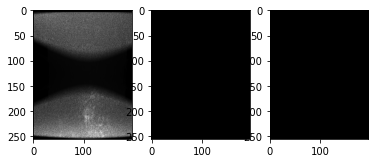

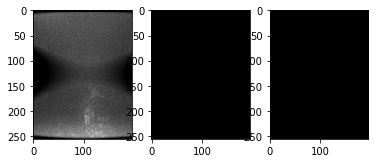

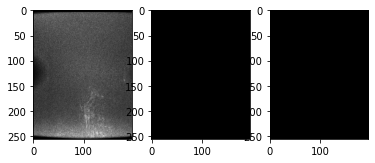

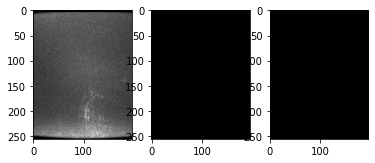

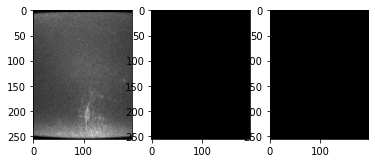

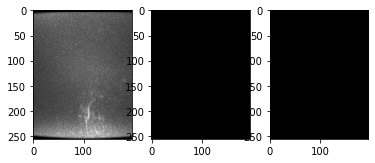

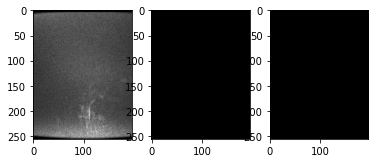

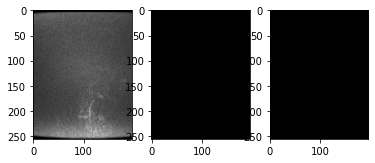

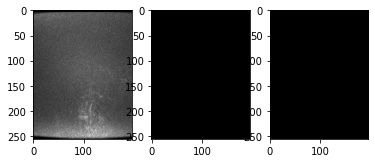

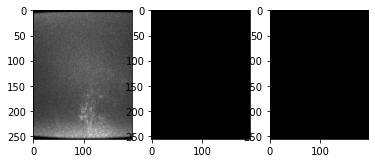

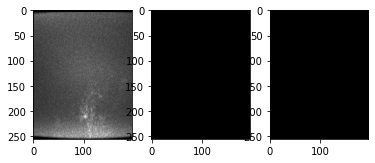

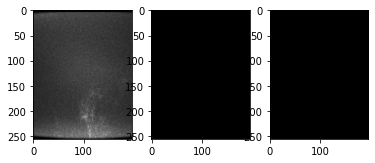

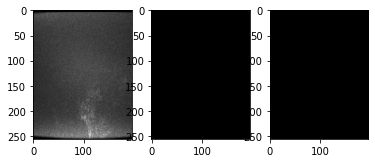

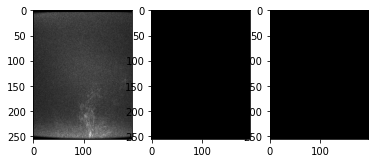

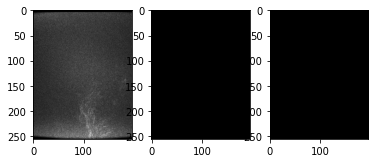

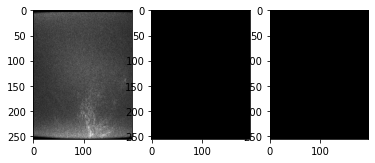

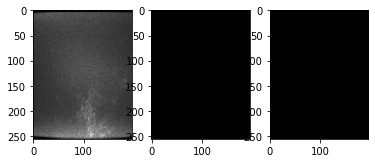

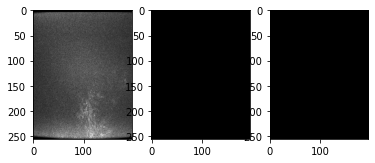

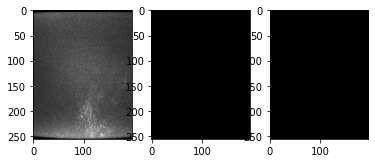

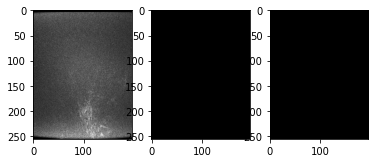

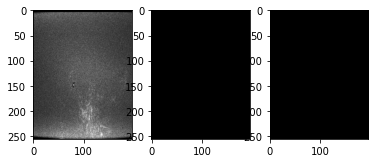

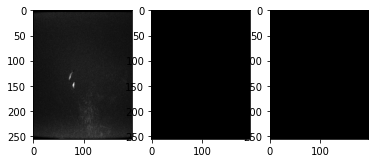

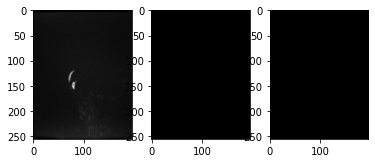

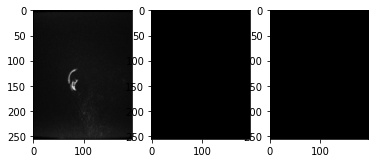

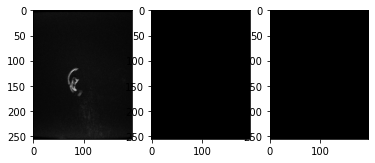

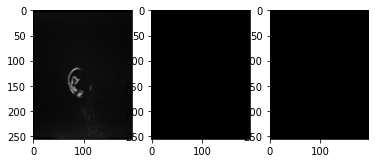

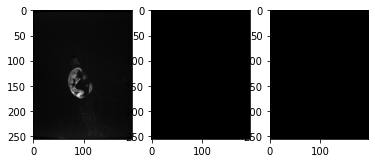

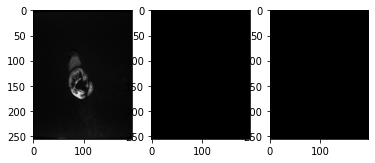

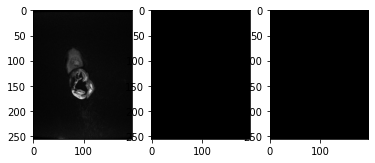

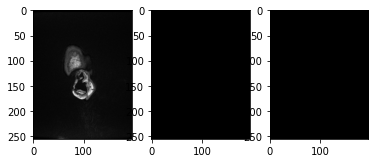

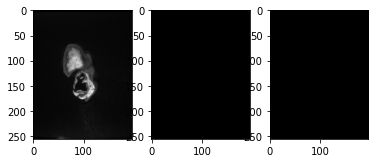

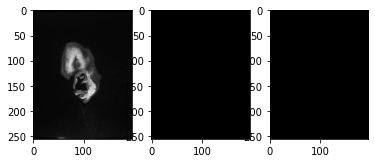

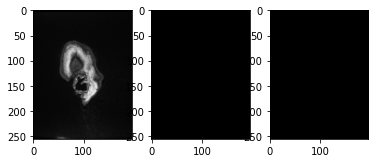

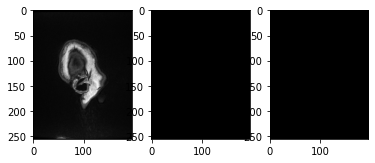

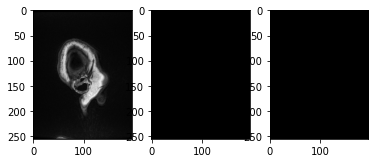

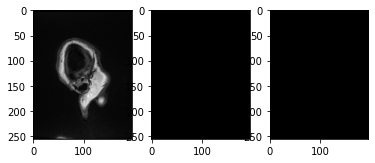

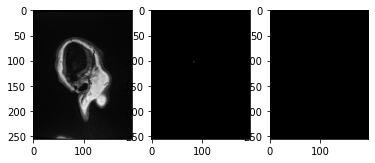

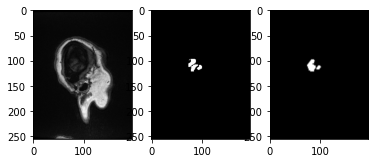

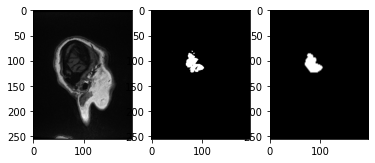

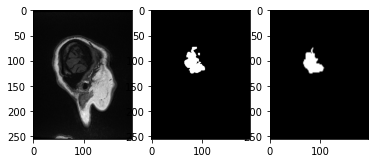

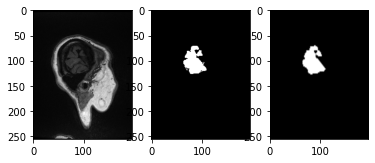

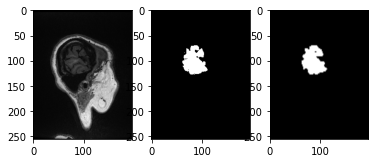

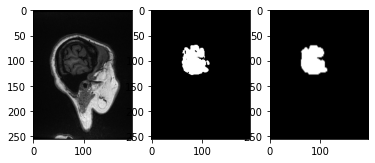

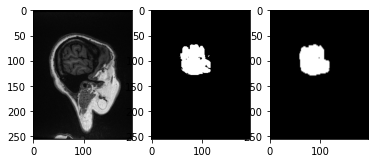

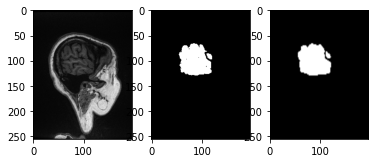

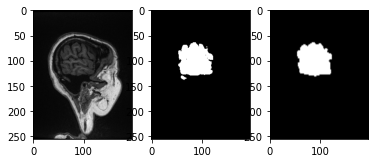

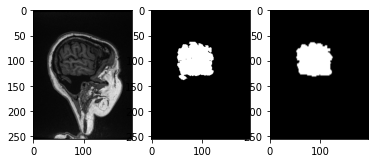

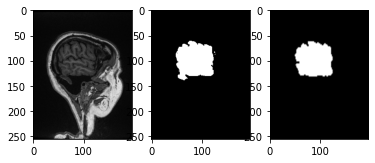

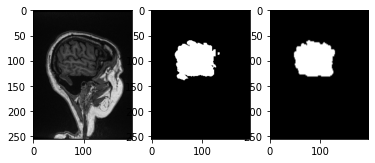

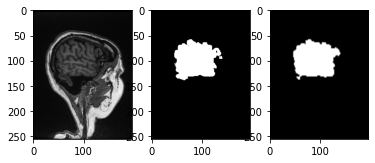

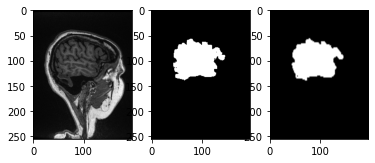

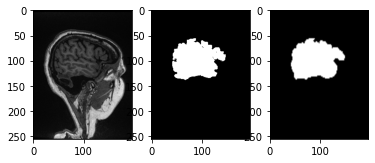

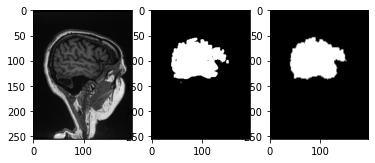

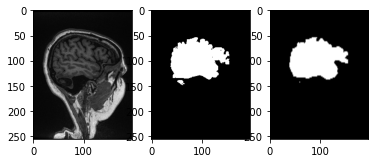

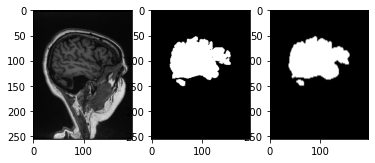

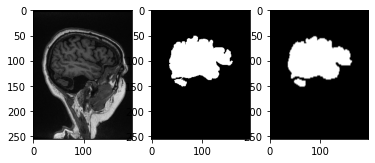

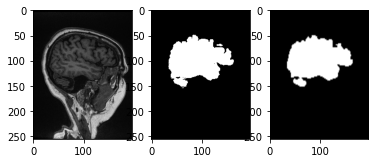

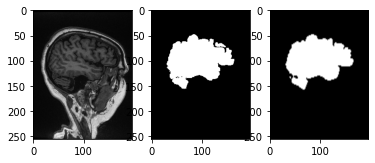

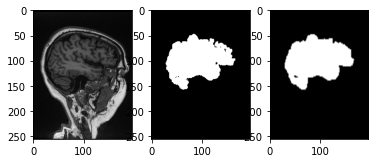

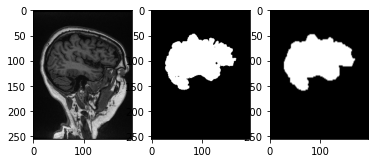

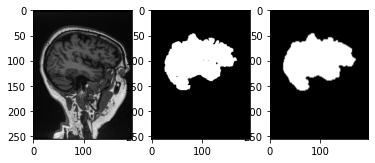

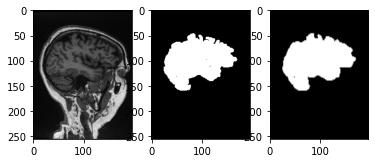

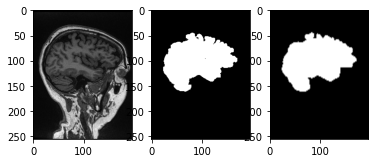

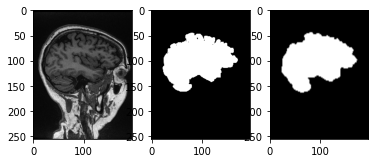

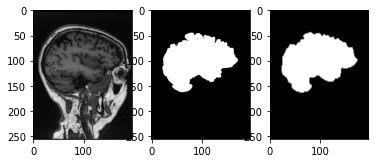

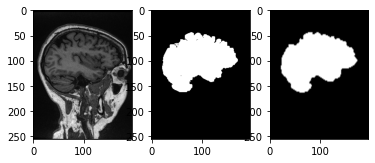

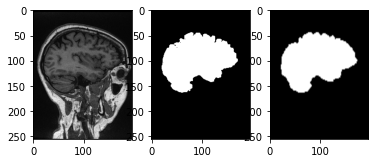

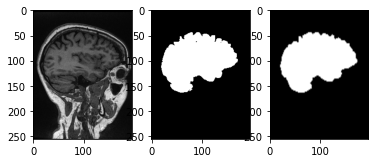

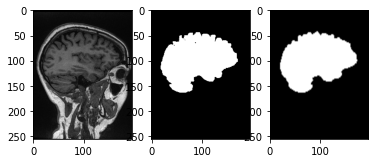

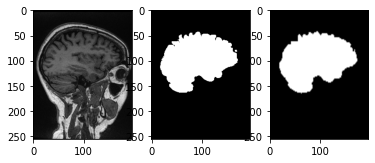

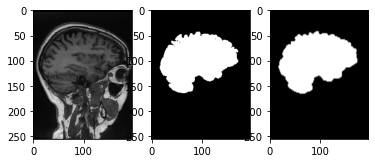

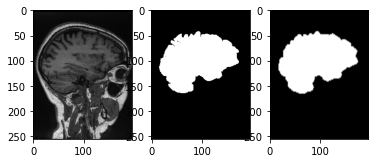

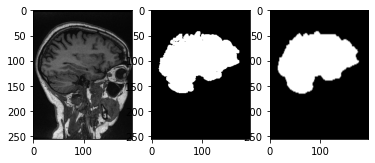

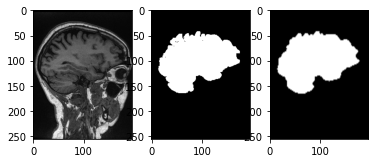

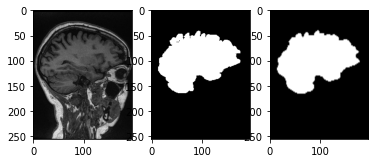

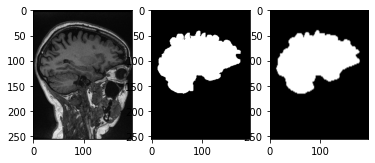

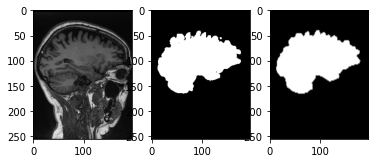

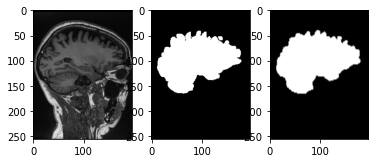

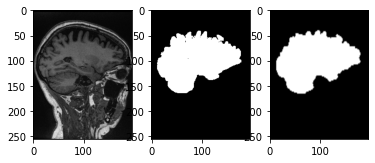

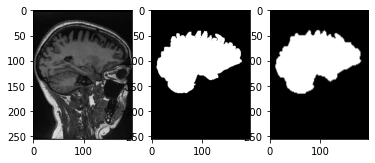

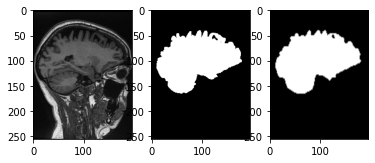

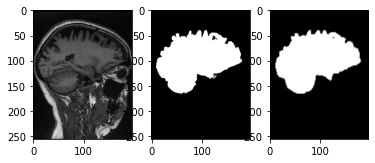

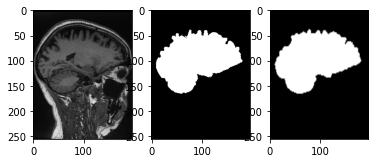

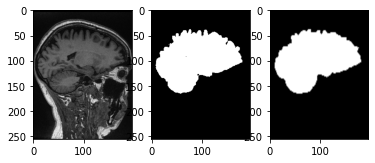

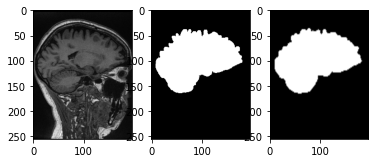

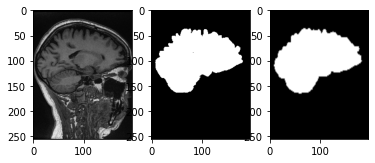

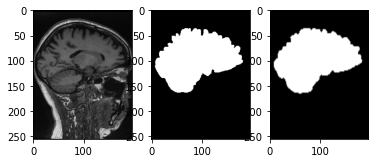

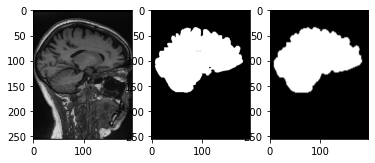

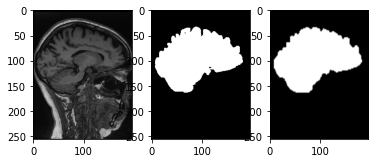

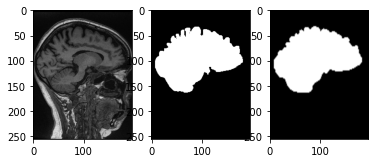

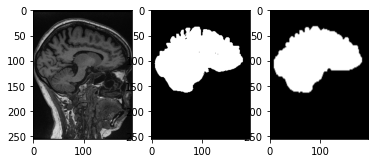

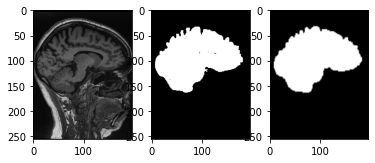

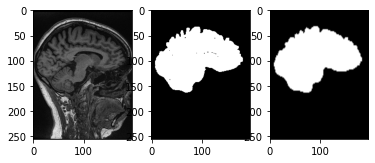

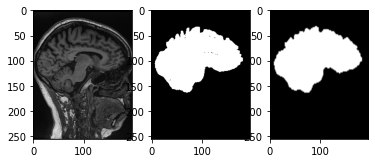

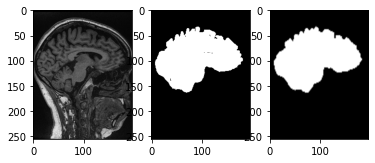

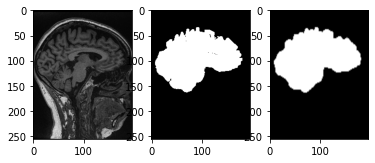

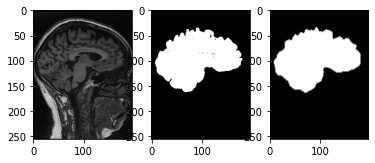

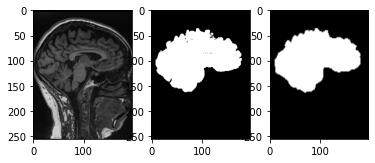

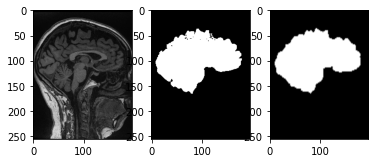

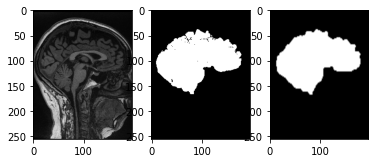

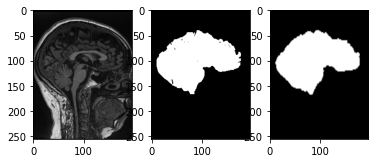

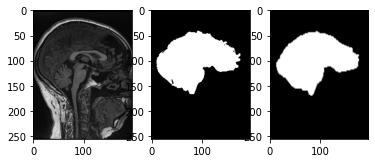

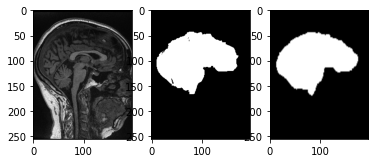

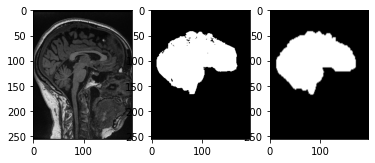

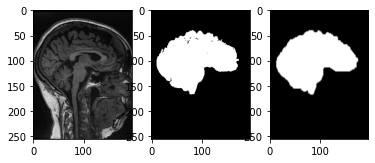

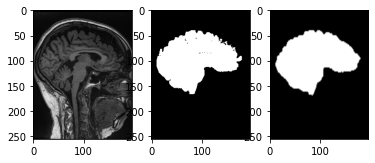

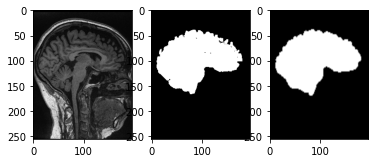

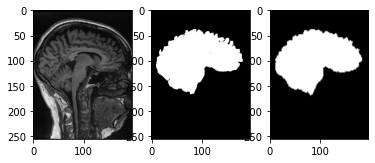

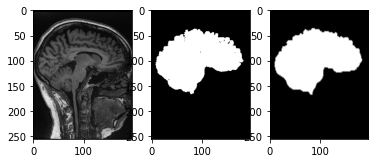

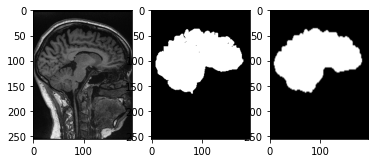

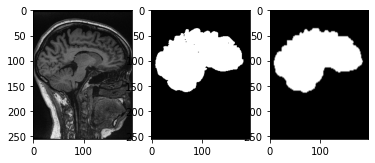

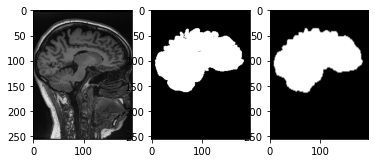

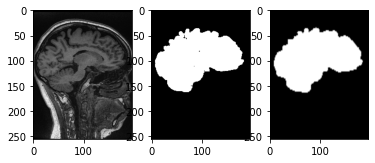

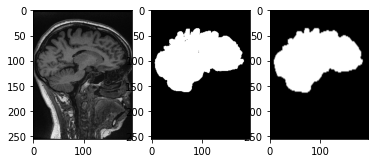

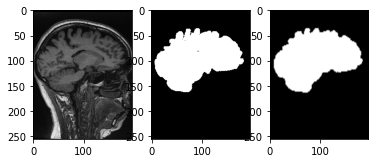

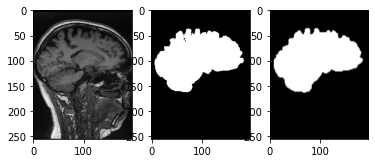

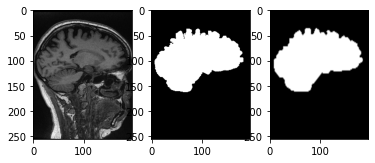

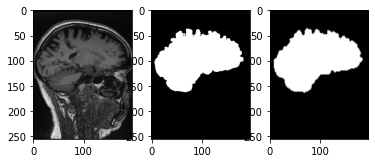

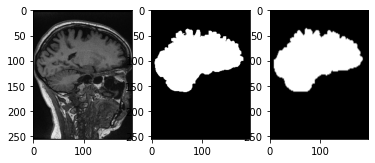

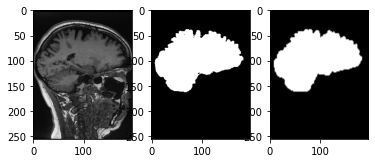

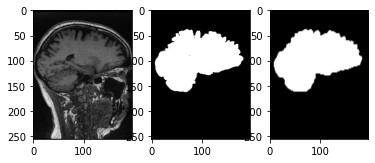

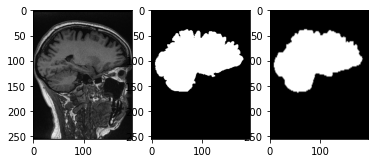

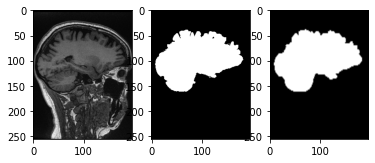

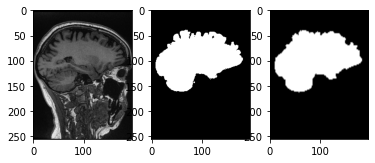

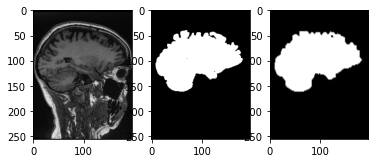

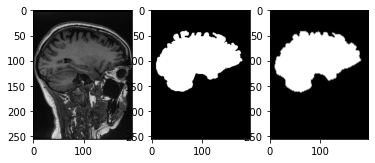

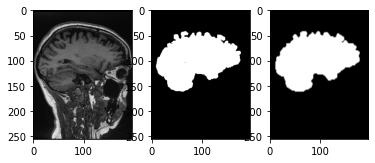

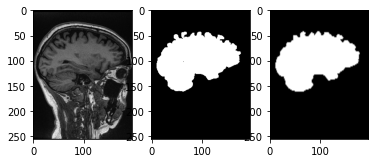

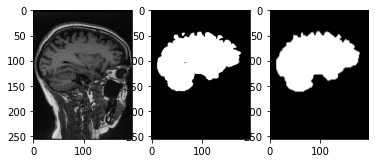

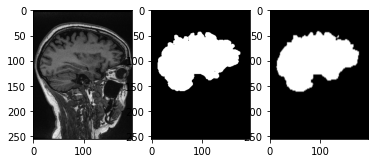

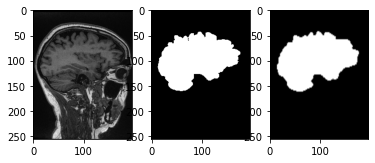

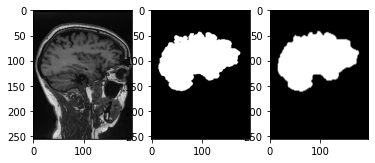

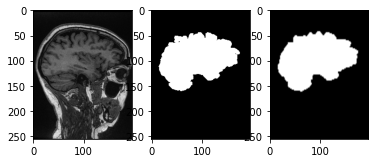

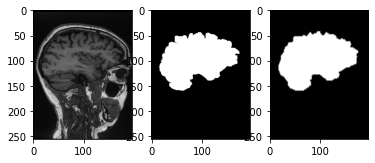

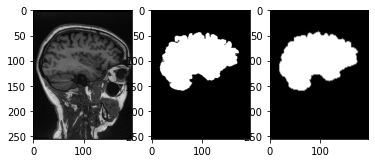

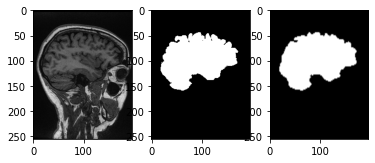

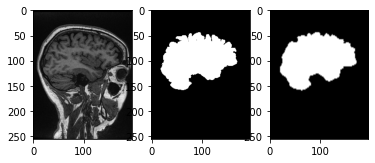

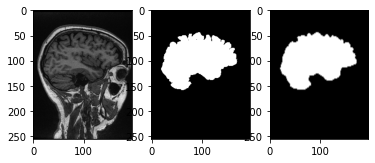

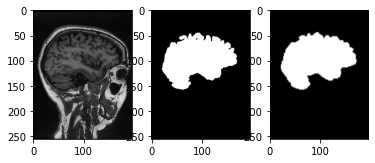

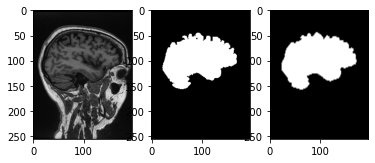

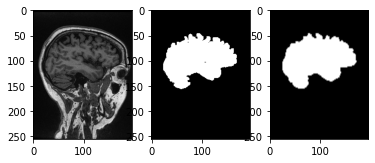

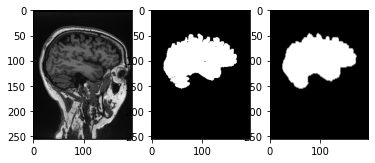

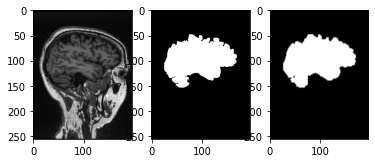

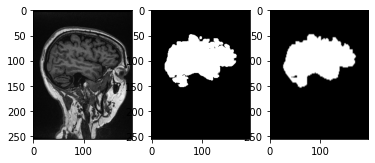

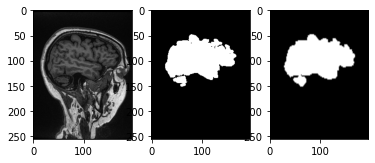

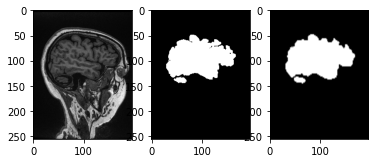

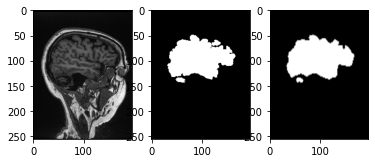

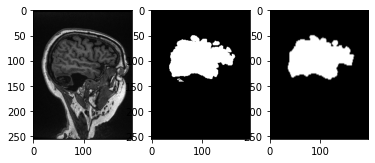

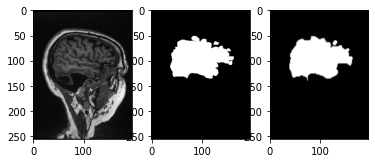

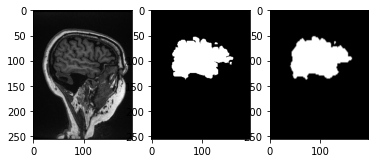

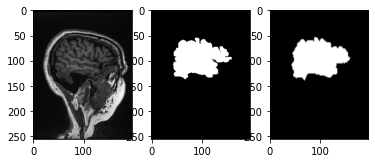

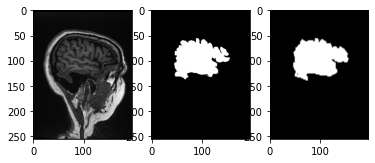

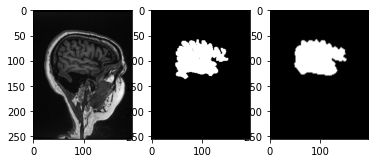

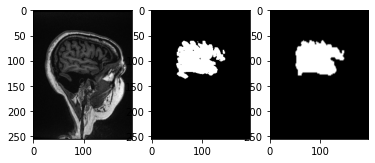

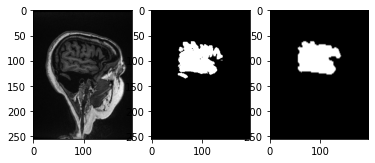

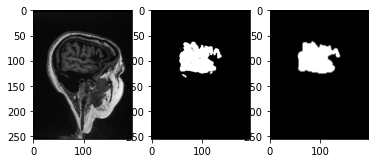

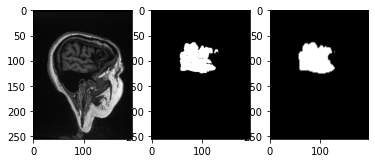

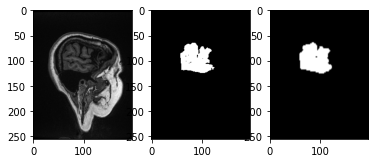

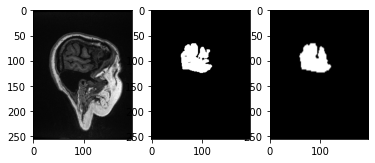

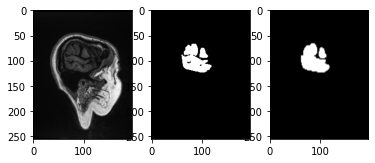

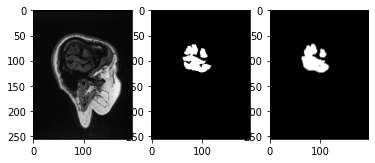

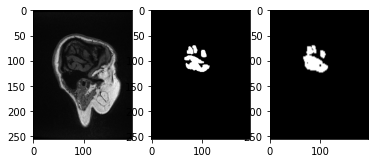

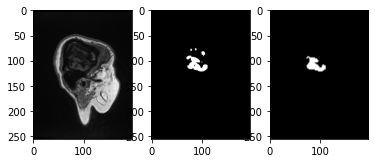

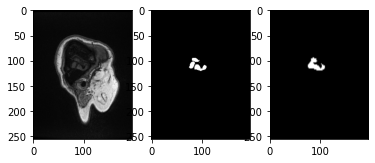

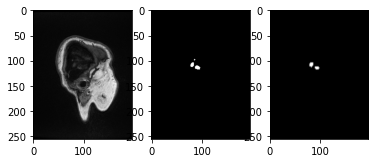

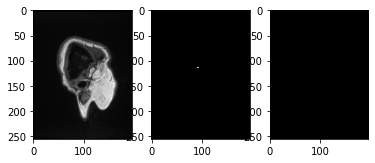

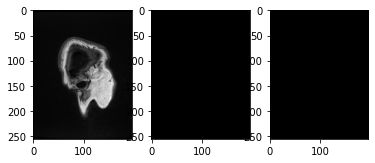

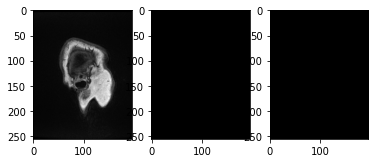

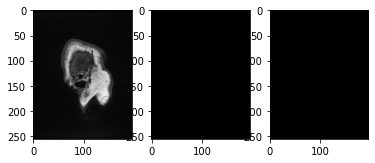

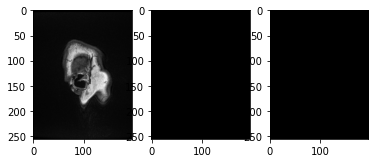

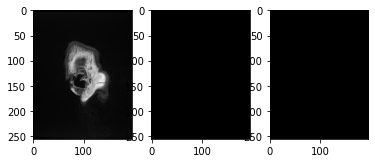

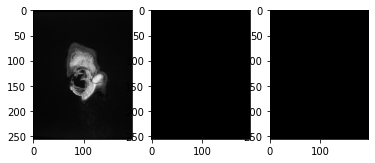

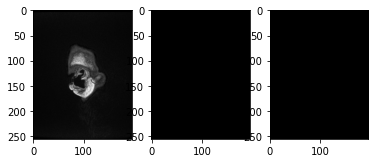

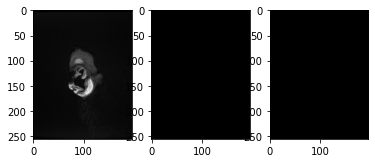

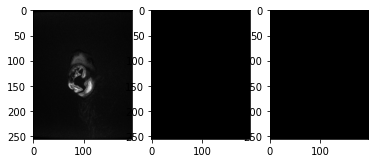

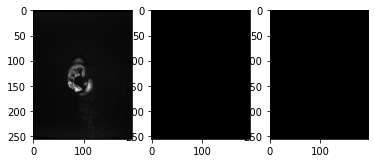

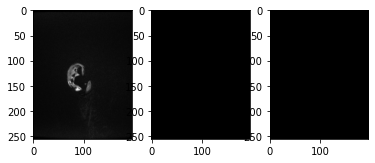

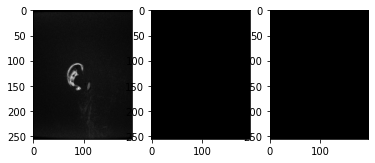

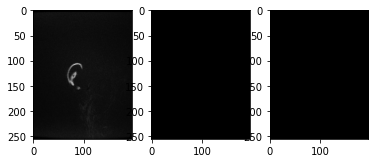

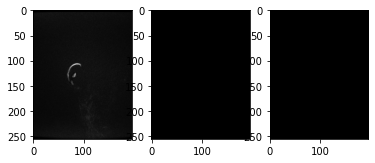

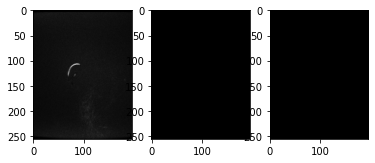

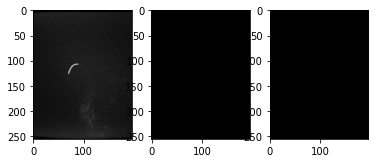

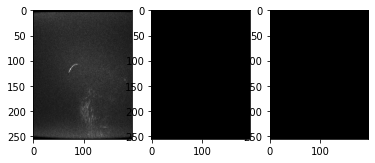

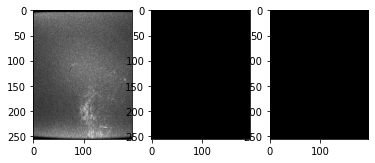

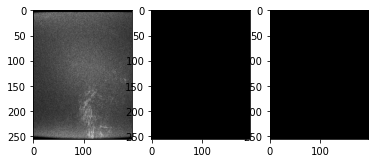

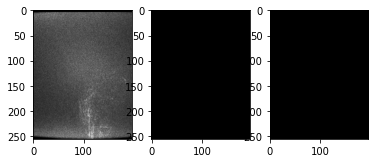

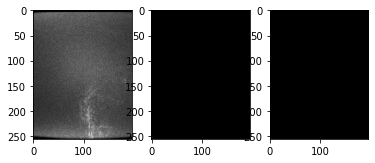

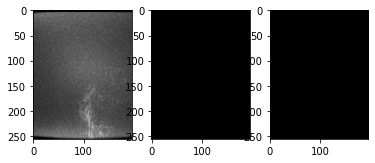

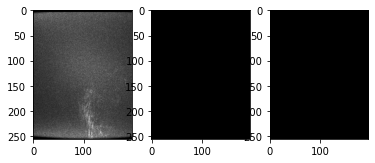

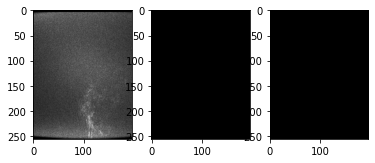

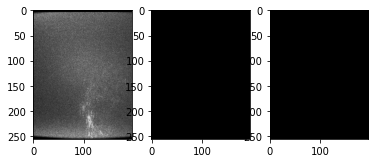

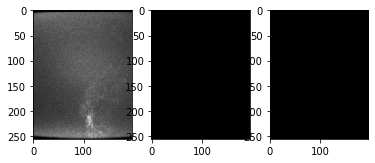

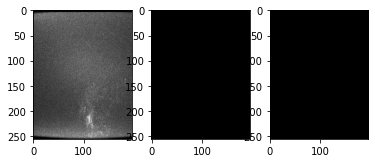

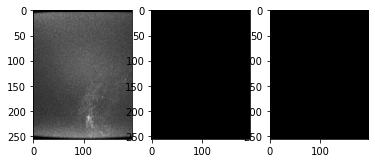

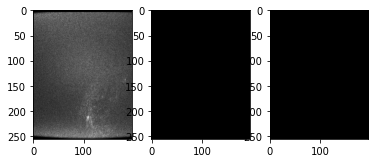

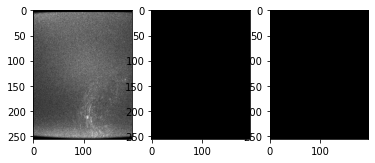

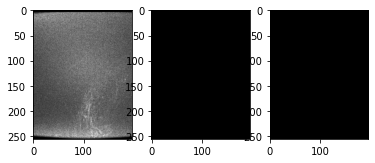

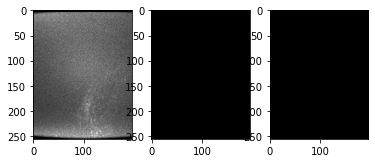

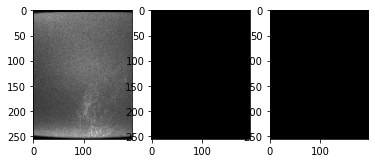

In [40]:
import scipy

scan_name = '3d477c3f6dbf4219c41c72ac0cdfc4a2.nii.gz'

path_to_orginal = '/content/FirstDataset/train/022161680299e1f3bea7169947dc45b6.nii.gz'
path_to_org_mask = '/content/FirstDataset/train/022161680299e1f3bea7169947dc45b6_mask.nii.gz'

raw_volume_oryginal, affine = load_raw_volume(path_to_orginal)
raw_volume_org_mask, affine = load_raw_volume(path_to_org_mask)

for slice_idx in range(raw_volume.shape[0]):


  volume_oryginal = raw_volume_oryginal[slice_idx]
  volume_org_mask = raw_volume_org_mask[slice_idx]

  #prediction

  data_max=np.amax(volume_oryginal)
  data_min=np.amin(volume_oryginal)

  data_slice = (volume_oryginal - data_min)/(data_max - data_min)

  data_slice = cv2.resize(data_slice, (128, 128))
  data_slice = data_slice[...,np.newaxis]
  data_slice = data_slice[np.newaxis,...]

  prediction = model.predict(data_slice)
  prediction = prediction.squeeze()

  prediction[prediction<0.05]=0
  prediction[prediction>=0.05]=1
  
  prediction = cv2.resize(prediction,(volume_oryginal.shape[1],volume_oryginal.shape[0]))


  # rotate

  volume_oryginal = scipy.ndimage.rotate(volume_oryginal, 90)
  volume_org_mask = scipy.ndimage.rotate(volume_org_mask, 90)
  prediction = scipy.ndimage.rotate(prediction, 90)

  fig = plt.figure()
  fig.add_subplot(1, 3, 1)
  plt.imshow(volume_oryginal, cmap="gray")
  fig.add_subplot(1, 3, 2)
  plt.imshow(volume_org_mask, cmap="gray")
  fig.add_subplot(1, 3, 3)
  plt.imshow(prediction, cmap="gray")
  plt.show()



